# Compare the distance matrices

This notebook can be used to compare the distance matrix obtained by 
* cosine distance s.t. it is defined in MS-cluster
* cosine distance between the high dimensional vectors of falcon 
* the ANN search used by falcon

In [1]:
import os
import sys
import joblib
import scipy.sparse as ss
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sys.path.append('..')
import config
from cluster import cluster, spectrum

import nb_utils
read_spectra = nb_utils.read_spectra
exact_sparse_matrix = nb_utils.exact_sparse_matrix
extract_nondiag_values = nb_utils.extract_nondiag_values
extract_n_neighbors = nb_utils.extract_n_neighbors
ss_generator = nb_utils.ss_generator

## The data sets to include in the comparison

In [2]:
data = {}

#data['erwinia'] = {'path': '/media/maesk/WD/falcon/erwinia'}
data['CCLE_Prot01'] = {'path': '/media/maesk/WD/falcon/CCLE_Protein_01'}
#data['CCLE'] = {'path': os.path.abspath("/media/maesk/WD/falcon/CCLE_all")}
data['PXD000561_22'] = {'path': os.path.abspath("/media/maesk/WD/falcon/PXD000561_22")}

charge = 2
exportPath = 'compareDistanceMatrices/' + '_'.join([l for l in data.keys()])
if not os.path.exists(exportPath):
    os.makedirs(exportPath)

### Compare the number of spectra for each charge

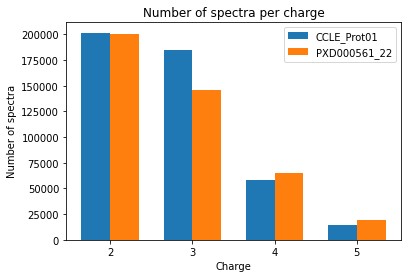

In [3]:
ds_keys = list(data.keys())
labels, nsp = [], []

for l in ds_keys:
    path = data[l]['path']
    charge_count = joblib.load(os.path.join(path, 'spectra', 'info.joblib'))
    labels.append(list(charge_count.keys()))
    nsp.append(list(charge_count.values()))

assert labels[0] == labels[1]

x = np.arange(len(labels[0]))
width = 0.35

fig, ax = plt.subplots()
for i in range(len(data)):
    ax.bar(x - width/2, nsp[i], width, label=ds_keys[i])
    x = x + width

ax.set_xticks(x-width*len(data))
ax.set_xticklabels(labels[0])
ax.legend()
ax.set(title=f"Number of spectra per charge",
       xlabel="Charge", ylabel="Number of spectra")

plt.savefig(os.path.join(exportPath, 'spectra_per_charge.png'), dpi=200)
plt.show()

### Plot the precursor mzs distributions (1 mz wide bins)

In [57]:
# Extract the precursor mzs for each dataset
for ds in data.values():
    precursor_mzs = []
    for spec in tqdm(read_spectra(charge, os.path.join(ds['path'], 'spectra'))):
        precursor_mzs.append(spec.precursor_mz)
        
    ds['precursor_mzs'] = precursor_mzs

fig, axs = plt.subplots(1, len(data), figsize=(12,4))
fig.suptitle(f'Precursos mz\' distribution (charge {charge})')
ds_names = list(data.keys())
for i in range(0,len(ds_names)):
    ds = data[ds_names[i]]
    min_mz = math.floor(min(ds['precursor_mzs']))
    max_mz = math.floor(max(ds['precursor_mzs']))
    bins = range(min_mz, max_mz+1, 1)
    axs[i].hist(ds['precursor_mzs'], bins=bins)
    axs[i].set(title=ds_names[i], xlabel="Precursor mz", ylabel="Number of spectra")

plt.tight_layout()
plt.savefig(os.path.join(exportPath, f'precursor_mzs_charge{charge}.png'), dpi=150)
plt.show()


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

KeyboardInterrupt: 

### Extract the distances computed by falcon


In [4]:
precursor_tol_mass = 20 # ppm

for ds_name, ds in data.items():
    dist_falcon = ss.load_npz(os.path.join(ds['path'], 'nn', f'dist_{charge}.npz'))
    ds['distance_falcon'] = dist_falcon
    n_spectra = dist_falcon.shape[0]

    print('Dataset: %s' % (ds_name,) )
    print('\tShape: (%d,%d)' % (n_spectra, n_spectra) )
    print('\tNumber of entries in the falcon matrix: %d \n' % (dist_falcon.nnz,) )

Dataset: CCLE_Prot01
	Shape: (200921,200921)
	Number of entries in the falcon matrix: 4026996 

Dataset: PXD000561_22
	Shape: (194597,194597)
	Number of entries in the falcon matrix: 5019146 



Compare the falcon distances for the different datasets

In [ ]:
dist = [extract_nondiag_values(ds['distance_falcon']) for ds in data.values()]
labels = [l for l in data.keys()]

fig, axs = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle(f"Distribution of the falcon distances (charge {charge}, non diagonal values)")

axs[0].boxplot(dist, labels=labels)
axs[0].set(title="Box plot",
           ylabel="Distance")

axs[1].hist(dist, histtype = 'bar', label = labels)
axs[1].set(title="Histogram",
       xlabel="Distance", ylabel="Number of entries")
axs[1].legend()

plt.savefig(os.path.join(exportPath, f'falcon_distances_distr_charge{charge}.png'), dpi=200)
plt.show()

Check how many neighbors each spectrum has in the falcon distance matrix

In [ ]:
thresholds = np.arange(1, 0, -0.1)

# Do not consider the spectrum itself as a neighbor
n_neighbors = [extract_n_neighbors(ds['distance_falcon'], thresholds) for ds in data.values()]
n_neighbors_1 = [nn[:,0] for nn in n_neighbors]

prop_neighbors = []
for nn in n_neighbors:
    mask = nn > 1
    n_thr = mask.sum(axis=0) / mask.shape[0]
    prop_neighbors.append(n_thr)

max_neighbors = int(max([np.max(l) for l in n_neighbors_1]))
#bins = range(1, max_neighbors + 1, 1)

fig, axs = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle("Neighbors of each spectrum in the falcon distance matrix")

axs[0].hist(n_neighbors_1, label=labels)
axs[0].set(title="Number of neighbors stored",
           xlabel="Number of neighbors", ylabel="Number of spectra")
#axs[0].set_xticks(bins)
axs[0].legend()

for i in range(0, len(n_neighbors)):
    axs[1].plot(thresholds, prop_neighbors[i], label=labels[i])
axs[1].set(title="Proportion of spectra having at least one neighbor at distance",
           xlabel="Distance", ylabel="Proportion of spectra")
axs[1].legend()


plt.savefig(os.path.join(exportPath, f'falcon_n_neighbors_charge{charge}.png'), dpi=200)
plt.show()

### Compare the falcon pairwise distance matrix with the MS-Cluster similarity

In [9]:
for ds_name, ds in data.items():
    path = os.path.join(ds['path'], 'nn', f'dist_msclustering_{charge}.npz')
    if(os.path.isfile(path)):
        dist_msclustering = ss.load_npz(path)
    else:
        dist_msclustering, _ = \
            exact_sparse_matrix(
                os.path.join(ds['path'], 'spectra'),
                charge,
                precursor_tol_mass,
                nb_utils.msclustering_distance)

        # Export the matrix
        ss.save_npz(path, dist_msclustering, False)

    ds['distance_msclustering'] = dist_msclustering

    dist_falcon = ds['distance_falcon']
    assert dist_falcon.shape == dist_msclustering.shape
    n_spectra = dist_msclustering.shape[0]
    n_lost = dist_msclustering.nnz - dist_falcon.nnz

    print('Dataset: %s' % (ds_name,) )
    print('\tShape: (%d,%d)' % (n_spectra, n_spectra) )
    print('\tNumber of entries in the exact matrix: %d' % (dist_msclustering.nnz,) )
    print('\tNumber of entries in the falcon matrix: %d' % (dist_falcon.nnz,) )
    print('\tNumber of spectra lost: %d' % (n_lost,) )
    print('\tProportion of spectra lost: %.4f %% \n\n' % (n_lost / (n_spectra**2) * 100 ,) )

Dataset: CCLE_Prot01
	Shape: (200921,200921)
	Number of entries in the exact matrix: 10154936
	Number of entries in the falcon matrix: 4026996
	Number of spectra lost: 6127940
	Proportion of spectra lost: 0.0152 % 


Dataset: PXD000561_22
	Shape: (194597,194597)
	Number of entries in the exact matrix: 11401225
	Number of entries in the falcon matrix: 5019146
	Number of spectra lost: 6382079
	Proportion of spectra lost: 0.0169 % 




In [ ]:
fig, axs = plt.subplots(2, len(data), figsize=(12,8) )
fig.suptitle("Comparison of the cosine distance measure: MS-clustering vs falcon")

cmax = [4*10**6, 1.5*10**6]

for ds_key, a in zip(list(data.keys()), range(len(data))):
    dist_mat_falcon = data[ds_key]['distance_falcon']
    dist_mat_msclustering = data[ds_key]['distance_msclustering']

    dists_falcon, dists_msclustering = [], []
    for i, j in tqdm(ss_generator(dist_mat_msclustering)):
        if nb_utils.ind_in_sparse(dist_mat_falcon, (i,j) ):
            dists_msclustering.append(dist_mat_msclustering[i,j])
            dists_falcon.append(dist_mat_falcon[i,j])
        else: # The falcon matrix "loses" some distances, the default distance is 1
            dists_msclustering.append(dist_mat_msclustering[i,j])
            dists_falcon.append(1)

    axs[0,a].scatter(dists_msclustering, dists_falcon, s=0.1)
    axs[0,a].set(title=ds_key,
           xlabel="Cosine distance (MS-clustering)",
           ylabel="Cosine distance (falcon, LD vectors)")

    h = axs[1,a].hist2d(dists_msclustering, dists_falcon, bins=[40, 40], cmap='gist_ncar', cmax=cmax[a])
    fig.colorbar(h[3], ax=axs[1,a])
    axs[1,a].set(xlabel="Cosine distance (HD vectors)", ylabel="Cosine distance (falcon, LD vectors)")

plt.tight_layout()
plt.savefig(os.path.join(exportPath, f'msclustering_vs_falcon_charge{charge}.png'), dpi=300)
plt.show()

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [ ]:
# TODO: add a 2D histogram

In [ ]:
thresholds = np.arange(1, 0, -0.1)

# Do not consider the spectrum itself as a neighbor
n_neighbors = [extract_n_neighbors(ds['distance_msclustering'], thresholds) for ds in data.values()]
n_neighbors_1 = [nn[:,0] for nn in n_neighbors]

prop_neighbors = []
for nn in n_neighbors:
    mask = nn > 1
    n_thr = mask.sum(axis=0) / mask.shape[0]
    prop_neighbors.append(n_thr)

In [ ]:
max_neighbors = int(max([np.max(l) for l in n_neighbors_1]))
bins = [0, 10, 20, 30, 40, 50, 60, 70]

fig, axs = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle("Neighbors of each spectrum in the MS-clustering distance matrix")

axs[0].hist(n_neighbors_1, label=labels, bins=bins)
axs[0].set(title="Number of neighbors stored",
           xlabel="Number of neighbors", ylabel="Number of spectra")
#axs[0].set_xticks(bins)
axs[0].legend()

for i in range(0, len(n_neighbors)):
    axs[1].plot(thresholds, prop_neighbors[i], label=labels[i])
axs[1].set(title="Proportion of spectra having at least one neighbor at distance",
           xlabel="Distance", ylabel="Proportion of spectra")
axs[1].legend()


plt.savefig(os.path.join(exportPath, f'msclustering_n_neighbors_charge{charge}.png'), dpi=200)
plt.show()

### Compare the falcon pairwise distance matrix with the HD similarity

The cosine similarity is computed with the high dimensional vectors, i.e. before the dimensionality
used by falcon.

In [6]:
for ds_name, ds in data.items():
    path = os.path.join(ds['path'], 'nn', f'dist_hdvectors_{charge}.npz')
    if(os.path.isfile(path)):
        dist_hdvectors = ss.load_npz(path)
    else:
        dist_hdvectors, _ = \
            exact_sparse_matrix(
                os.path.join(ds['path'], 'spectra'),
                charge,
                precursor_tol_mass,
                nb_utils.hdvectors_distance)
        # Export the matrix
        ss.save_npz(path, dist_hdvectors, False)
    ds['distance_hdvectors'] = dist_hdvectors

    dist_falcon = ds['distance_falcon']
    assert dist_falcon.shape == dist_hdvectors.shape

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

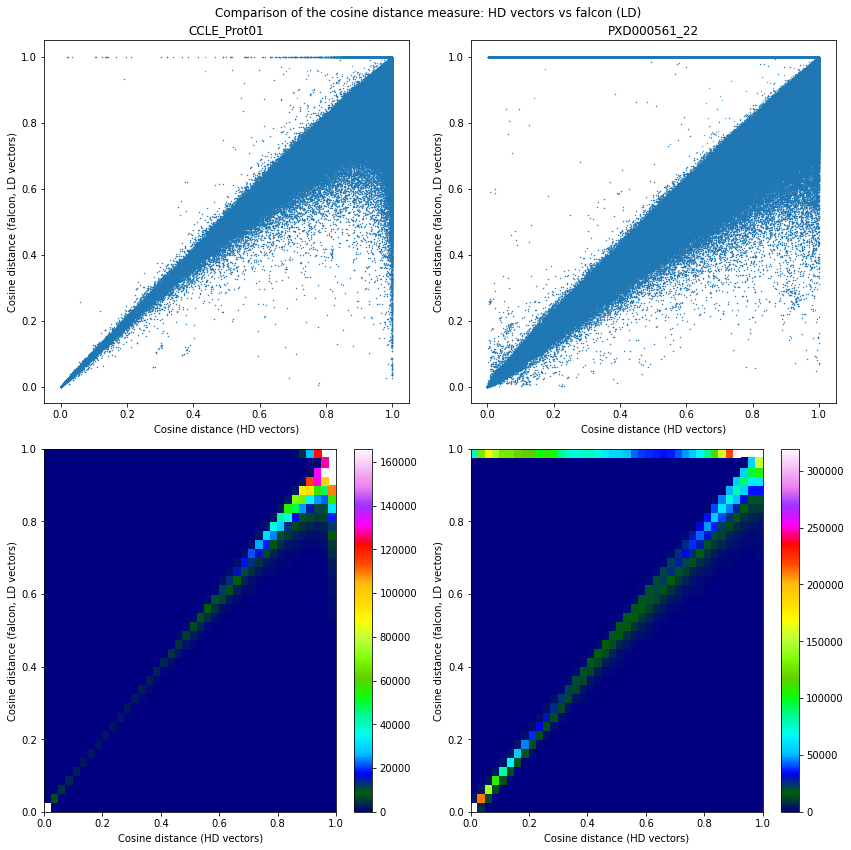

In [8]:
fig, axs = plt.subplots(2, len(data), figsize=(12,12) )
fig.suptitle("Comparison of the cosine distance measure: HD vectors vs falcon (LD)")

cmax = [175000, 400000] # Depends on the dataset!

for ds_key, a in zip(list(data.keys()), range(len(data))):
    dist_mat_falcon = data[ds_key]['distance_falcon']
    dist_mat_hdvectors = data[ds_key]['distance_hdvectors']

    dists_falcon, dists_hdvectors = [], []
    for i, j in tqdm(ss_generator(dist_mat_hdvectors)):
        if nb_utils.ind_in_sparse(dist_mat_falcon, (i,j) ):
            dists_hdvectors.append(dist_mat_hdvectors[i,j])
            dists_falcon.append(dist_mat_falcon[i,j])
        else: # The falcon matrix "loses" some distances, the default distance is 1
            dists_hdvectors.append(dist_mat_hdvectors[i,j])
            dists_falcon.append(1)

    axs[0,a].scatter(dists_hdvectors, dists_falcon, s=0.1)
    axs[0,a].set(title=ds_key,
           xlabel="Cosine distance (HD vectors)",
           ylabel="Cosine distance (falcon, LD vectors)")

    h = axs[1,a].hist2d(dists_hdvectors, dists_falcon, bins=[40, 40], cmap='gist_ncar', cmax=cmax[a])
    fig.colorbar(h[3], ax=axs[1,a])
    axs[1,a].set(xlabel="Cosine distance (HD vectors)", ylabel="Cosine distance (falcon, LD vectors)")

    #h = axs[2,a].hist2d(dists_hdvectors, dists_falcon, bins=[40, 40], range=[[0, 0.9], [0, 0.9]],
    #          cmap='gist_ncar')
    #fig.colorbar(h[3], ax=axs[2,a])
    #axs[2,a].set(xlabel="Cosine distance (HD vectors)", ylabel="Cosine distance (falcon, LD vectors)")

plt.tight_layout()
plt.savefig(os.path.join(exportPath, f'hdvectors_vs_falcon_charge{charge}.png'), dpi=300)
plt.show()

### Comparison of the distance distribution with the different distance measures

In [ ]:
fig, axs = plt.subplots(1, len(data), figsize=(12,4) )

for ds_key, ax in zip(list(data.keys()), axs):
    ds = data[ds_key]
    dist_labels = ['distance_msclustering', 'distance_hdvectors', 'distance_falcon']
    dists = [extract_nondiag_values(ds[l]) for l in dist_labels]
    ax.boxplot(dists)
    ax.set(title=ds_key,
           ylabel="Cosine distance")
    ax.set_xticklabels(dist_labels, rotation=20)

plt.savefig(os.path.join(exportPath, f'dist_distr_measures_charge{charge}.png'), dpi=300)
plt.show()

### Plot the clusters stats for CCLE_Prot01 and PXD000561_22 (all charges)

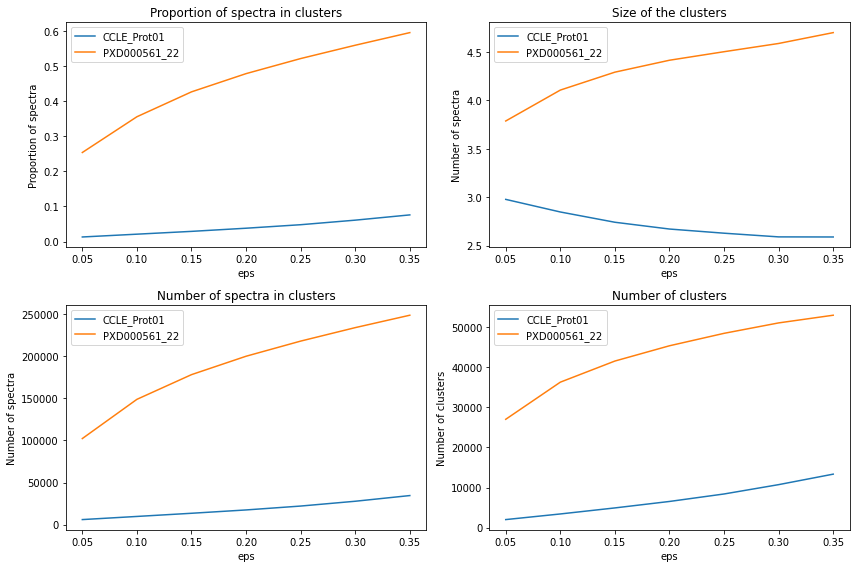

In [62]:
ds_names = ["CCLE_Prot01", "PXD000561_22"]
eps =     [0.35,  0.30,   0.25,   0.20,   0.15,   0.10,   0.05]
propsp = [[0.076, 0.061,  0.048,  0.038,  0.029,  0.021,  0.013], # CCLE
          [0.596, 0.560,  0.522,  0.479,  0.427,  0.356,  0.254]] # PXD
clsize = [[2.589, 2.590,  2.628,  2.671,  2.741,  2.847,  2.977],
          [4.698, 4.586,  4.501,  4.413,  4.290,  4.105,  3.786]]
nclsp =  [[34524, 27772,  22067,  17449,  13493,  9727,   6002],
         [248690, 233951, 217955, 199980, 178118, 148799, 102229]]
nclst =  [[13337, 10722,  8396,   6532,   4922,   3417,   2016],
         [52932,  51017,  48419,  45320,  41515,  36252,  27004]]

fig, axs = plt.subplots(2,2, figsize=(12,8) )

# The proportion of clustered spectra
axs[0,0].plot(eps, propsp[0])
axs[0,0].plot(eps, propsp[1])
axs[0,0].set(title="Proportion of spectra in clusters",
             xlabel="eps", ylabel="Proportion of spectra")
axs[0,0].legend(ds_names)

axs[0,1].plot(eps, clsize[0])
axs[0,1].plot(eps, clsize[1])
axs[0,1].set(title="Size of the clusters",
             xlabel="eps", ylabel="Number of spectra")
axs[0,1].legend(ds_names)

axs[1,0].plot(eps, nclsp[0])
axs[1,0].plot(eps, nclsp[1])
axs[1,0].set(title="Number of spectra in clusters",
             xlabel="eps", ylabel="Number of spectra")
axs[1,0].legend(ds_names)

axs[1,1].plot(eps, nclst[0])
axs[1,1].plot(eps, nclst[1])
axs[1,1].set(title="Number of clusters",
             xlabel="eps", ylabel="Number of clusters")
axs[1,1].legend(ds_names)

plt.tight_layout()
plt.savefig(os.path.join(exportPath, 'stats.png'), dpi=300)
plt.show()

Sanity check: verify that all elements in the falcon distance matrix are in the
exact matrice. The falcon matrix will contain less elements because:
* It only contains *n_neighbors* entries for each spectrum
* Spectra with close precursor mzs in neighboring buckets are not compared

For small datasets (less than 1000 spectra per bucket), such that no partitioning is used
and a bruteforce approach is used, the following sanity tests should pass if *n_neighbors*
is large enough.

In [ ]:
"""assert len(indices_lost( (dist_falcon, dist_exact) )) == 0
print("OK, all the entries of the falcon matrix are in the exact matrix")

assert len(indices_lost( (dist_exact, dist_falcon) )) == n_missed_sp
print("OK, all the indices lost correspond to spectra in different buckets")"""